# Causal modelling

**Inputs:**
- data/heart_disease_cleaned.csv

**Outputs:**
- models/traces/posterior_samples_full.nc
- data/fair_heart_disease_full.csv


## Setup and imports

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
else:
  PROJECT_ROOT = '../'

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample
import arviz as az

from google.colab import output
# output.enable_custom_widget_manager()
output.disable_custom_widget_manager()

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

In [3]:
heart_disease = pd.read_csv(f'{PROJECT_ROOT}/data/heart_disease_cleaned.csv')

### Relationships in data

We explore the statistical association between the clinical features and the target outcome, sex and age respectively. This will help us parameterise our causal model.

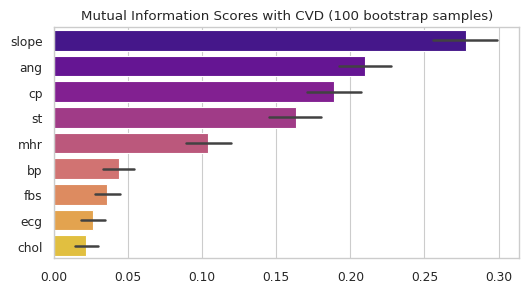

In [4]:
# Mutual information of clinical features with CVD
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['cvd']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', estimator='mean', palette='plasma')
plt.title('Mutual Information Scores with CVD (100 bootstrap samples)')
plt.show()

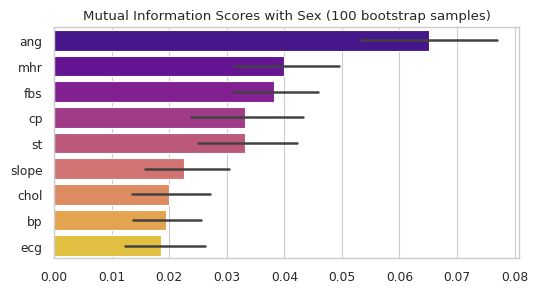

In [5]:
# Mutual information of clinical features with Sex
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['sex']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Sex (100 bootstrap samples)')
plt.show()

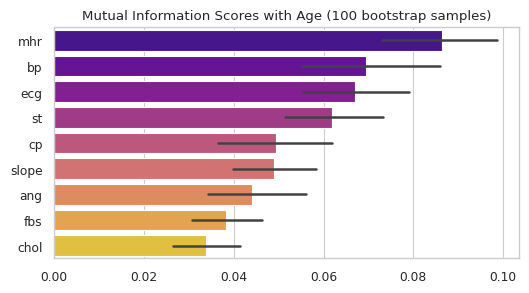

In [6]:
# Mutual information of clinical features with Age
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['age']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Age (100 bootstrap samples)')
plt.show()

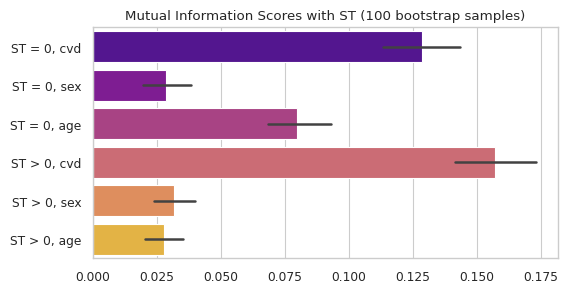

In [7]:
# Mutual information of ST with CVD, Sex and Age
N_MI = 100

# We decompose ST into two components: a binary feature zero_ct (True if ST=0),
# and for patients with zero_ct = False, non_zero_ct with takes non-null values of ST
zero_st = heart_disease['st'] == 0
X_zero = heart_disease[['cvd','sex','age']]
y_zero = zero_st

X_non_zero = heart_disease.loc[heart_disease['st'] > 0, ['cvd','sex','age']]
y_non_zero = heart_disease.loc[heart_disease['st'] > 0, 'st']

mi_results = []

for i in range(N_MI):
  X_zero_resampled, y_zero_resampled = resample(X_zero, y_zero, n_samples=50, random_state=i)
  mi_scores_zero = mutual_info_regression(X_zero_resampled, y_zero_resampled, n_neighbors=5, random_state=4)
  X_non_zero_resampled, y_non_zero_resampled = resample(X_non_zero, y_non_zero, n_samples=50, random_state=i)
  mi_scores_non_zero = mutual_info_regression(X_non_zero_resampled, y_non_zero_resampled, n_neighbors=5, random_state=4)
  mi_scores = np.concatenate([mi_scores_zero, mi_scores_non_zero])
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=['ST = 0, cvd', 'ST = 0, sex', 'ST = 0, age',
                    'ST > 0, cvd', 'ST > 0, sex', 'ST > 0, age'])

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with ST (100 bootstrap samples)')
plt.show()

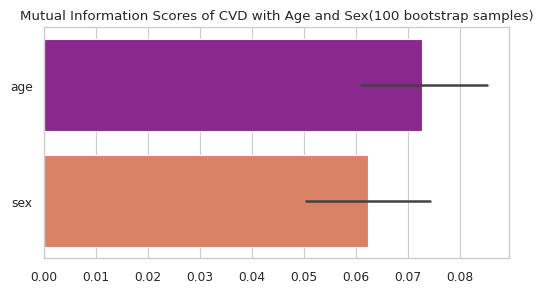

In [8]:
# Mutual information of CVD with Age and Sex
X = heart_disease[['age', 'sex']]
y = heart_disease['cvd']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores of CVD with Age and Sex(100 bootstrap samples)')
plt.show()

## Causal Modelling

From the feature set observed in the [Heart Disease (CAD) dataset](https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive), using clinical knowledge in the literature and strong assumptions, we create a causal model that we will use to:
1. Test the counterfactual fairness of the baseline predictive model
2. Create a counterfactually fair predictive model

### Causal assumptions

We hypothesise that clinical features in the CAD dataset are manifestations of a patient's **Age- and Sex-independent Physiological Integrity**, which we define as our fair latent variable $U$. It is independent of the protected attributes $S_{bio}$ and $S_{soc}$.

We postulate that subjective symptoms and clinician-dependent interpretations are influenced by Sociological Sex ($S_{soc}$). This creates an unfair pathway where the recorded value of a feature is not solely a manifestation of the patient's physiological state, but is also a product of external factors:
- Reporting bias: how a patient describes symptoms like chest pain based on gendered expectations
- Diagnostic bias: how a clinician interprets those symptoms, potentially mislabeling 'atypical' presentations in women

We assume that objective biomarkers such as cholesterol, maximum heart rate, resting blood pressure, fasting blood sugar, and measurements related to the ECG ST slope, are only influenced by the **biological sex** ($S_{bio}$), and are therefore fair pathways for the predictor.

Age is considered as the sole independent variable from $S_{bio}$ and $S_{soc}$.

**Structural equations:**

| Feature | Variable name | Variable type | Model distribution |
|:---|:---|:---|:---|
|Chest Pain Type | $CP$|Categorical|Categorical|
|Exercise Induced Angina | $Ang$|Binary|Bernoulli|
|Resting ECG Result | $ECG$|Categorical|Categorical|
|Max Heart Rate |$MHR$ |Numerical| Normal |
|Fasting Blood Sugar |$FBS$ |Binary|Bernoulli|
|Oldpeak |$ST$ |Numerical| Zero-Inflated Log-Normal |
|ST Slope |$Slope$ |Categorical|Categorical|
|Resting Blood Pressure | $BP$|Numerical| Log-Normal |
|Serum Cholesterol | $Chol$ |Numerical| Log-Normal |
|Age- and Sex-independent Physiological Integrity | $U$|Numerical| Normal |
|Cardiovascular Disease (target outcome) | $Y$|Binary|Bernoulli|

<br>

- $CP = f_{CP}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{CP} + \beta_{CP, U}U + \beta_{CP,S_{soc}}S_{soc} + \beta_{CP,Age}Age))$

- $Ang = f_{Ang}(U, S_{soc}, Age) \sim  \text{Bernoulli}(\text{invlogit}(\alpha_{Ang} + \beta_{Ang, U}U + \beta_{Ang,soc}S_{soc} + \beta_{Ang,Age}Age))$

- $ECG = f_{ECG}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{ECG} + \beta_{ECG, U}U + \beta_{ECG,soc}S_{soc} + \beta_{ECG,Age}Age))$

- $MHR = f_{MHR}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{MHR} + \beta_{MHR,U}U + \beta_{MHR,bio}S_{bio} + \beta_{MHR,Age}Age, \sigma_{MHR})$

- $FBS = f_{FBS}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{FBS} + \beta_{FBS,U}U + \beta_{FBS,bio}S_{bio} + \beta_{FBS,Age}Age))$

- $ST = f_{ST}(U, S_{bio}, Age) \sim \text{ZeroInflatedLogNormal}(\psi_{ST}, \mu_{ST}, \sigma_{ST})$

  - where $\psi_{ST} = \text{invlogit}(\alpha_{\psi} + \beta_{\psi,U}U + \beta_{\psi,bio}S_{bio} + \beta_{\psi,Age}Age)$
  - and $\mu_{ST} = \alpha_{\mu} + \beta_{\mu,U}U + \beta_{\mu,bio}S_{bio}  + \beta_{\mu,Age}Age$

- $Slope =f_{Slope}(U, S_{bio}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{Slope} + \beta_{Slope, U}U + \beta_{Slope,bio}S_{bio} + \beta_{Slope,Age}Age)) $

- $BP = f_{BP}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{BP} + \beta_{BP,U}U + \beta_{BP,bio}S_{bio} + \beta_{BP,Age}Age, \sigma_{BP})$

- $Chol=  f_{Chol}(U, S_{bio}, Age) \sim \text{Normal}(\alpha_{Chol} + \beta_{Chol,U}U + \beta_{Chol,bio}S_{bio} + \beta_{Chol,Age}Age, \sigma_{Chol})$

- $Y = f_{Y}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{Y} + \beta_{Y, U}U + \beta_{Y,bio}S_{bio} + \beta_{Y,Age}Age)) $

- $U \sim \mathcal{N}(0, 1) $


### Evidence-based prior selection

In our causal model, each clinical feature $X$ is defined as a function of the target outcome (via the latent variable U), sex and age:
$$X \sim f(\alpha_X + \beta_{X, U}U + \beta_{X,Sex}Sex + \beta_{X,Age}Age)$$

We model the $\beta$ coefficients as normally distributed around 0. The standard variation ($\sigma$) of these coefficients is the 'degree of freedom' granted to the MCMC algorithm to establish a causal link with parent variables. Selecting the correct $\sigma$ involves a critical trade-off:

- **High $\sigma$**: If $\sigma$ is high, the model can capture strong causal relationships. However, if the feature $X$ contains little information about a parent variable ($U$, $Age$ or $Sex$), the sampler will struggle to converge as it searches for a non-existent relationship

- **Low $\sigma$**: If $\sigma$ is too restrictive, we risk "flattening" the model, forcing the $\beta$ coefficients to zero and losing legitimate causal pathways

To move beyond arbitrary parameterisation, we calibrate $\sigma$ based on the result of our Mutual Information analysis:

| Statistical evidence (MI) | Causal signal $P_X → X$ | Prior model parameter ($\sigma$) for $\beta_{X, P_X}$|
| --- | --- | --- |
| < 0.05 | Low | 0.2 |
| 0.05 - 0.15 | Medium | 0.4 |
| > 0.15 | High | 0.75 |

Based on this rule, we choose the following parameters:

| Clinical feature $X$ | $\sigma_{X, U}$ | $\sigma_{X, Sex}$ | $\sigma_{X, Age}$ |
|:---|:---:|:---:|:---:|
| **Slope** | 0.75 | 0.4 | 0.2 |
| **Exercise Angina ($Ang$)** | 0.75 | 0.2 | 0.2 |
| **Chest Pain Type ($CP$)** | 0.75 | 0.2 | 0.4 |
| **Max Heart Rate ($MHR$)** | 0.4 | 0.2 | 0.4 |
| **Resting BP ($BP$)** | 0.2 | 0.2 | 0.4 |
| **Resting ECG ($ECG$)** | 0.2 | 0.2 | 0.4 |
| **Fasting Blood Sugar ($FBS$)** | 0.2 | 0.2 | 0.2 |
| **Serum Cholesterol ($Chol$)** | 0.2 | 0.2 | 0.2 |
| **Oldpeak = 0 ($ST$)** | 0.4 | 0.2 | 0.4 |
| **Oldpeak > 0 ($ST$)** | 0.75 | 0.2 | 0.2 |

### Causal inference

In [ ]:
with pm.Model() as causal_model:
  # 1. EVIDENCE & PRIORS:
  # Fixed predictors
  age = heart_disease['age'].values
  sex = heart_disease['sex'].values
  N = len(heart_disease)

  # The prior for U, the age- and sex- independent physiological integrity
  # Non-centred parametrisation
  U_raw = pm.Normal('U_raw', mu=0, sigma=1, shape=N)
  sigma_U = pm.HalfNormal('sigma_U', sigma=1)
  U = pm.Deterministic('U', U_raw*sigma_U)

  # 2. LIKELIHOODS: Variables likelihoods
  alpha_cp = pm.Normal('alpha_cp', mu=0, sigma=1, shape=4)
  beta_U_cp = pm.math.concatenate([[0],pm.Normal('beta_U_cp', mu=0, sigma=.75, shape=3)])
  beta_sex_cp = pm.math.concatenate([[0],pm.Normal('beta_sex_cp', mu=0, sigma=.4, shape=3)])
  beta_age_cp = pm.math.concatenate([[0],pm.Normal('beta_age_cp', mu=0, sigma=.2, shape=3)])
  cp = pm.Categorical('cp',
            logit_p=alpha_cp + beta_U_cp*U[:,None] + beta_sex_cp*sex[:,None] + beta_age_cp*age[:,None],
            observed=heart_disease['cp'])

  alpha_ang = pm.Normal('alpha_ang', mu=0, sigma=1)
  beta_U_ang = pm.Normal('beta_U_ang', mu=0, sigma=.75)
  beta_sex_ang = pm.Normal('beta_sex_ang', mu=0, sigma=.2)
  beta_age_ang = pm.Normal('beta_age_ang', mu=0, sigma=.2)
  ang = pm.Bernoulli('ang',
            logit_p=alpha_ang + beta_U_ang*U + beta_sex_ang*sex + beta_age_ang*age,
            observed=heart_disease['ang'])

  alpha_ecg = pm.Normal('alpha_ecg', mu=0, sigma=1, shape=3)
  beta_U_ecg = pm.math.concatenate([[0],pm.Normal('beta_U_ecg', mu=0, sigma=.2, shape=2)])
  beta_sex_ecg = pm.math.concatenate([[0],pm.Normal('beta_sex_ecg', mu=0, sigma=.2, shape=2)])
  beta_age_ecg = pm.math.concatenate([[0],pm.Normal('beta_age_ecg', mu=0, sigma=.4, shape=2)])
  ecg = pm.Categorical('ecg',
            logit_p=alpha_ecg + beta_U_ecg*U[:,None] + beta_sex_ecg*sex[:,None] + beta_age_ecg*age[:,None],
            observed=heart_disease['ecg'])

  alpha_mhr = pm.Normal('alpha_mhr', mu=0, sigma=1)
  beta_U_mhr = pm.Normal('beta_U_mhr', mu=0, sigma=.4)
  beta_sex_mhr = pm.Normal('beta_sex_mhr', mu=0, sigma=.2)
  beta_age_mhr = pm.Normal('beta_age_mhr', mu=0, sigma=.4)
  sigma_mhr = pm.HalfNormal('sigma_mhr', sigma=1)
  mhr = pm.Normal('mhr',
            mu=alpha_mhr + beta_U_mhr*U + beta_sex_mhr*sex + beta_age_mhr*age,
            sigma=sigma_mhr,
            observed=heart_disease['mhr'])

  alpha_fbs = pm.Normal('alpha_fbs', mu=0, sigma=1)
  beta_U_fbs = pm.Normal('beta_U_fbs', mu=0, sigma=.75)
  beta_sex_fbs = pm.Normal('beta_sex_fbs', mu=0, sigma=.4)
  beta_age_fbs = pm.Normal('beta_age_fbs', mu=0, sigma=.2)
  fbs = pm.Bernoulli('fbs',
            logit_p=alpha_fbs + beta_U_fbs*U + beta_sex_fbs*sex + beta_age_fbs*age,
            observed=heart_disease['fbs'])

  alpha_slope = pm.Normal('alpha_slope', mu=0, sigma=1, shape=3)
  beta_U_slope = pm.math.concatenate([[0],pm.Normal('beta_U_slope', mu=0, sigma=.25, shape=2)])
  beta_sex_slope = pm.math.concatenate([[0],pm.Normal('beta_sex_slope', mu=0, sigma=.25, shape=2)])
  beta_age_slope = pm.math.concatenate([[0],pm.Normal('beta_age_slope', mu=0, sigma=.25, shape=2)])
  slope = pm.Categorical('slope',
            logit_p=alpha_slope + beta_U_slope*U[:,None] + beta_sex_slope*sex[:,None] + beta_age_slope*age[:,None],
            observed=heart_disease['slope'])

  alpha_bp = pm.Normal('alpha_bp', mu=0, sigma=1)
  beta_U_bp = pm.Normal('beta_U_bp', mu=0, sigma=.2)
  beta_sex_bp = pm.Normal('beta_sex_bp', mu=0, sigma=.2)
  beta_age_bp = pm.Normal('beta_age_bp', mu=0, sigma=.4)
  sigma_bp = pm.HalfNormal('sigma_bp', sigma=1)
  bp = pm.Normal('bp',
            mu=alpha_bp + beta_U_bp*U + beta_sex_bp*sex + beta_age_bp*age,
            sigma=sigma_bp,
            observed=heart_disease['bp'])

  alpha_chol = pm.Normal('alpha_chol', mu=0, sigma=1)
  beta_U_chol = pm.Normal('beta_U_chol', mu=0, sigma=.2)
  beta_sex_chol = pm.Normal('beta_sex_chol', mu=0, sigma=.2)
  beta_age_chol = pm.Normal('beta_age_chol', mu=0, sigma=.2)
  sigma_chol = pm.HalfNormal('sigma_chol', sigma=1)
  chol = pm.Normal('chol',
            mu=alpha_chol + beta_U_chol*U + beta_sex_chol*sex + beta_age_chol*age,
            sigma=sigma_chol,
            observed=heart_disease['chol'])

  # CUSTOM DIST. for Oldpeak (ST): Zero-inflated Log-normal
  # Probability of being exactly zero
  alpha_zero_st = pm.Normal('alpha_zero_st', mu=0, sigma=.5)
  beta_U_zero_st = pm.Normal('beta_U_zero_st', mu=0, sigma=.4)
  beta_sex_zero_st = pm.Normal('beta_sex_zero_st', mu=0, sigma=.2)
  beta_age_zero_st = pm.Normal('beta_age_zero_st', mu=0, sigma=.4)
  psi_st = pm.math.invlogit(alpha_zero_st + beta_U_zero_st*U + beta_sex_zero_st*sex + beta_age_zero_st*age)

  # Log-normal parameters
  non_zero_st = heart_disease['st'][heart_disease['st'] > 0]
  alpha_init_st = np.log(non_zero_st.mean()) if len(non_zero_st) > 0 else 0
  alpha_st = pm.Normal('alpha_st', mu=0, sigma=1, initval=alpha_init_st)
  beta_U_st = pm.Normal('beta_U_st', mu=0, sigma=.75)
  beta_sex_st = pm.Normal('beta_sex_st', mu=0, sigma=.2)
  beta_age_st = pm.Normal('beta_age_st', mu=0, sigma=.2)
  sigma_st = pm.HalfNormal('sigma_st', sigma=1)
  mu_st = alpha_st + beta_U_st*U + beta_sex_st*sex + beta_age_st*age
  sigma_st = sigma_st

  # Probability function for the custom distribution
  def zero_inflated_lognormal(value, psi, mu, sigma):
    # Log-probability for the zero cases
    logp_zero = pm.math.log(psi)

    # Log-probability for the non-zero cases
    safe_value = pm.math.switch(pm.math.eq(value, 0), 1.0, value)
    logp_nonzero = pm.math.log(1 - psi) + pm.logp(pm.LogNormal.dist(mu=mu, sigma=sigma), safe_value)

    return pm.math.switch(pm.math.eq(value, 0), logp_zero, logp_nonzero)

  # Define the custom distribution
  st = pm.CustomDist('st',
                     psi_st, mu_st, sigma_st,
                     logp=zero_inflated_lognormal,
                     observed=heart_disease['st'])


  # 3. INFERENCE of U with MCMC
  posterior_samples = pm.sample(target_accept=0.95)

In [ ]:
import os
save_path = f'{PROJECT_ROOT}/results/traces'
os.makedirs(save_path, exist_ok=True)

posterior_samples.to_netcdf(f'{save_path}/posterior_samples_full.nc')
print('Posterior samples saved')

Posterior samples saved


In [ ]:
# FAIR DATASET

# Define the number of samples (m) taken for each individual from the infered posterior
m = 50

# Extract the U samples from the posterior
samples = az.extract(posterior_samples, var_names=['U'],
                                          combined=True, num_samples=20).to_dataframe().reset_index()

# Merge samples with original dataset
heart_disease_reset = heart_disease.reset_index(drop=True)
aug_heart_disease = heart_disease_reset.merge(samples, left_index=True, right_on='U_dim_0')

# Fair dataset:
# Keep only sex-independent variables (age), latent fair variable U, and outcome CVD
fair_heart_disease = aug_heart_disease[['U_dim_0','age','U','sex','cvd']].rename(columns={'U_dim_0':'ID'})
fair_heart_disease.to_csv(f'{PROJECT_ROOT}/data/fair_heart_disease_full.csv', index=False)
print('Fair dataset saved')

Fair dataset saved
